<div style='background-image: url("../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">ObsPy Tutorial</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Handling Waveform Data</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Tobias Megies ([@megies](https://github.com/megies))
* Lion Krischer ([@krischer](https://github.com/krischer))
---

![](images/obspy_logo_full_524x179px.png)

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')


<img src="images/Stream_Trace.svg" width=90%>

* read waveform data is returned as a **`Stream`** object.

In [ ]:
from obspy import read
st = read("./data/waveform_PFO.mseed")
print(st)

- UNIX wildcards can be used to read multiple files simultaneously
- automatic file format detection, no need to worry about file formats

  - currently supported: **mseed, sac, segy, seg2, gse1/2, seisan, sh, datamark, css, wav, y, Q (keeps growing...)**
  - more file formats are included whenever a basic reading routine is provided (or e.g. sufficient documentation on data compression etc.)
  - custom user-specific file formats can be added (through plugin) to filetype autodiscovery in local ObsPy installation by user

In [ ]:
from obspy import read
st = read("./data/waveform_*")
print(st)

- for MiniSEED files, only reading short portions of files without all of the file getting read into memory is supported (saves time and memory when working on large collections of big files)

In [ ]:
from obspy import UTCDateTime

t = UTCDateTime("2011-03-11T05:46:23.015400Z")
st = read("./data/waveform_*", starttime=t + 10 * 60, endtime=t + 12 * 60)
print(st)

#### The Stream Object

 - A Stream object is a collection of Trace objects

In [ ]:
from obspy import read
st = read("./data/waveform_PFO.mseed")
print(type(st))

In [ ]:
print(st)

In [ ]:
print(st.traces)

In [ ]:
#print(st[0])
tr = st[1]
print(tr)

- More traces can be assembled using **`+`** operator (or using the `.append()` and `.extend()` methods)

In [ ]:
st1 = read("./data/waveform_PFO.mseed")
st2 = read("./data/waveform_PFO_synthetics.mseed")

st = st1 + st2
print(st)

st3 = read("./data/waveform_BFO_BHE.sac")

st += st3
print(st)

 - convenient (and nicely readable) looping over traces

In [ ]:
for tr in st:
    print(tr.id)

 - Stream is useful for applying the same processing to a larger number of different waveforms or to group Traces for processing (e.g. three components of one station in one Stream)

#### The Trace Object

- a Trace object is a single, contiguous waveform data block (i.e. regularly spaced time series, no gaps)
- a Trace object contains a limited amount of metadata in a dictionary-like object (as **`Trace.stats`**) that fully describes the time series by specifying..
  * recording location/instrument (network, station, location and channel code)
  * start time
  * sampling rate

In [ ]:
st = read("./data/waveform_PFO.mseed")
tr = st[0]  # get the first Trace in the Stream
print(tr)

In [ ]:
print(tr.stats)
tr.stats
tr.data

- For custom applications it is sometimes necessary to directly manipulate the metadata of a Trace.
- The metadata of the Trace will **stay consistent**, as all values are derived from the starttime, the data and the sampling rate and are **updated automatically**

In [ ]:
print(tr.stats.delta, "|", tr.stats.endtime)

In [ ]:
tr.stats.sampling_rate = 5.0
print(tr.stats.delta, "|", tr.stats.endtime)

In [ ]:
print(tr.stats.npts)

In [ ]:
tr.data = tr.data[:100]
print(tr.stats.npts, "|", tr.stats.endtime)

- convenience methods make basic manipulations simple

In [ ]:
tr = read("./data/waveform_PFO.mseed")[0]
tr.plot()
tr.stats

In [ ]:
print(tr)
tr.resample(sampling_rate=100.0)
print(tr)

In [ ]:
print(tr)
tr.trim(tr.stats.starttime + 12 * 60, tr.stats.starttime + 14 * 60)
print(tr)
tr.plot()

In [ ]:
tr.detrend("linear")
tr.taper(max_percentage=0.05, type='cosine')
tr.filter("lowpass", freq=0.1)
tr.plot()

In [ ]:
# try tr.<Tab> for other methods defined for Trace
tr.decimate?

- Raw data available as a [**`numpy.ndarray`**](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) (as **`Trace.data`**)

In [ ]:
print(tr.data[:20])

- Data can be directly modified e.g. ..

..by doing arithmetic operations (fast, handled in C by NumPy)

In [ ]:
tr1 = tr.copy()
tr1.data = tr.data ** 2 + 0.5
tr1.plot()
print(tr.data ** 2 + 0.5)

..by using [**`numpy.ndarray`** builtin methods](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) (also done in C by NumPy)

In [ ]:
print(tr1.data.max())
print(tr1.data.mean())
print(tr1.data.ptp())
# try tr.data.<Tab> for a list of numpy methods defined on ndarray

..by using **`numpy`** functions (also done in C by NumPy)

In [ ]:
import numpy as np
print(np.abs(tr.data))
# you can try np.<Tab> but there is a lot in there
# try np.a<Tab>

..by feeding pointers to existing C/Fortran routines from inside Python!

This is done internally in several places, e.g. for cross correlations, beamforming or in third-party filetype libraries like e.g. libmseed.

- Trace objects can also be manually generated with data in a [**`numpy.ndarray`**](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) (e.g. when needing to parse waveforms from non-standard ascii files)

In [ ]:
from obspy import Trace

x = np.random.randint(-100, 100, 500)
tr = Trace()
tr.data = x
tr = Trace(data=x)
tr.stats.station = "XYZ"
tr.stats.starttime = UTCDateTime()

tr.plot()

- Stream objects can be assembled from manually generated Traces

In [ ]:
from obspy import Stream

tr2 = Trace(data=np.random.randint(-300, 100, 1000))
tr2.stats.starttime = UTCDateTime()
tr2.stats.sampling_rate = 10.0
st = Stream()
st.append(tr)
st.append(tr2)

st.plot()

#### Builtin methods defined on **`Stream`** / **`Trace`**

- Most methods that work on a Trace object also work on a Stream object. They are simply executed for every trace. [See ObsPy documentation for an overview of available methods](http://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html) (or try **`st.<Tab>`**).
 - **`st.filter()`** - Filter all attached traces.
 - **`st.trim()`** - Cut all traces.
 - **`st.resample()`** / **`st.decimate()`** - Change the sampling rate.
 - **`st.trigger()`** - Run triggering algorithms.
 - **`st.plot()`** / **`st.spectrogram()`** - Visualize the data.
 - **`st.attach_response()`**/**`st.remove_response()`**, **`st.simulate()`** - Instrument correction
 - **`st.merge()`**, **`st.normalize()`**, **`st.detrend()`**, **`st.taper()`**, ...
- A **`Stream`** object can also be exported to many formats, so ObsPy can be used to convert between different file formats.

In [ ]:
st = read("./data/waveform_*.sac")
st.write("output_file.mseed", format="MSEED")
!ls -l output_file*

<img src="images/Stream_Trace.svg" width=90%>

#### Trace Exercises
 - Make an **`numpy.ndarray`** with zeros and (e.g. use **`numpy.zeros()`**) and put an ideal pulse somewhere in it
 - initialize a **`Trace`** object with your data array
 - Fill in some station information (e.g. network, station, ..)
 - Print trace summary and plot the trace
 - Change the sampling rate to 20 Hz
 - Change the starttime of the trace to the start time of this session
 - Print the trace summary and plot the trace again

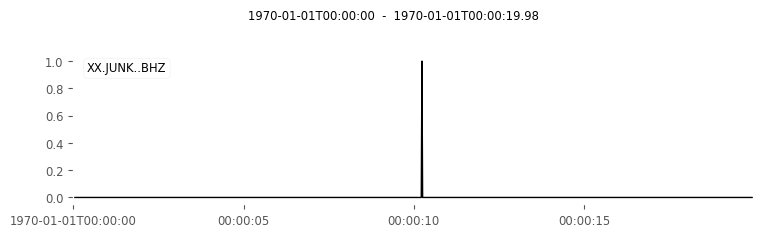

XX.JUNK..BHZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:19.980000Z | 50.0 Hz, 1000 samples


In [4]:
from obspy import *
import numpy as np

tr = Trace()
x = np.zeros(1000)
tr.data = x
tr.data[512] = 1
tr.stats.station = "JUNK"
tr.stats.network = "XX"
tr.stats.channel = "BHZ"
tr.stats.sampling_rate = 50.
tr.plot()
print(tr)

- Use **`tr.filter(...)`** and apply a lowpass filter with a corner frequency of 1 Hertz.
- Display the preview plot, there are a few seconds of zeros that we can cut off.

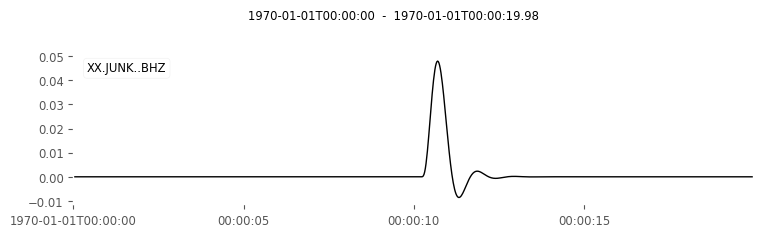

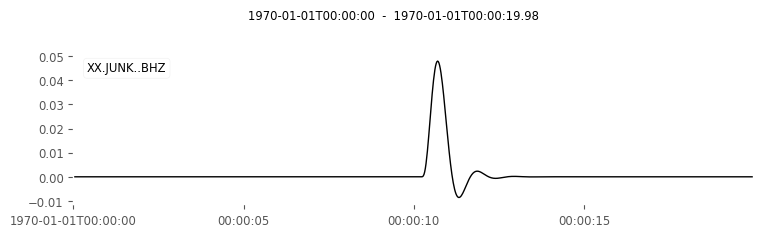

In [6]:
tr.filter("lowpass",freq=1.0)
tr.plot()

- Use **`tr.trim(...)`** to remove some of the zeros at start and at the end
- show the preview plot again

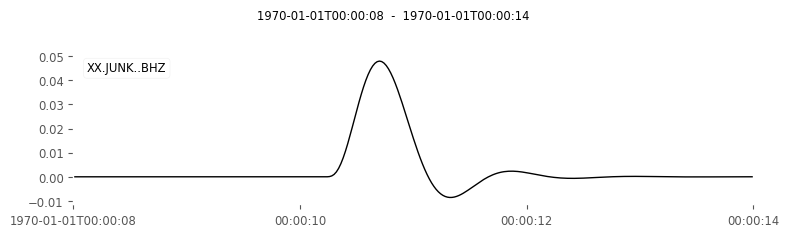

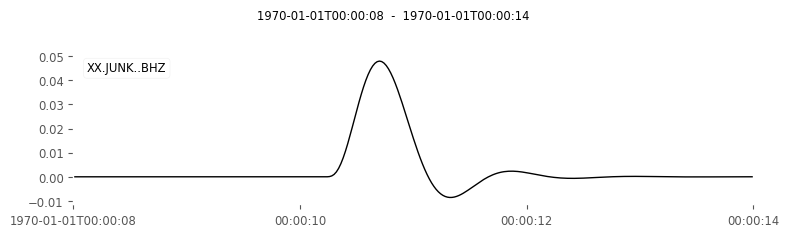

In [7]:
start = UTCDateTime(1970,1,1,0,0,8)
tr.trim(start,start+6)
tr.plot()

- Scale up the amplitudes of the trace by a factor of 500
- Add standard normal gaussian noise to the trace (use [**`np.random.randn()`**](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html))
- Display the preview plot again

#### Stream Exercises

- Read all Tohoku example earthquake data into a stream object ("./data/waveform\_\*")
- Print the stream summary

In [8]:
st = read("./data/waveform_*")
print(st)

8 Trace(s) in Stream:
GR.BFO..BHE   | 2011-03-11T05:46:23.021088Z - 2011-03-11T06:36:22.971088Z | 20.0 Hz, 60000 samples
GR.BFO..BHN   | 2011-03-11T05:46:23.021088Z - 2011-03-11T06:36:22.971088Z | 20.0 Hz, 60000 samples
GR.BFO..BHZ   | 2011-03-11T05:46:23.021088Z - 2011-03-11T06:36:22.971088Z | 20.0 Hz, 60000 samples
II.PFO.00.BHZ | 2011-03-11T05:46:23.019500Z - 2011-03-11T06:36:22.969500Z | 20.0 Hz, 60000 samples
II.PFO.10.BHZ | 2011-03-11T05:46:23.019500Z - 2011-03-11T06:36:22.994500Z | 40.0 Hz, 120000 samples
SY.PFO.S3.MXE | 2011-03-11T05:47:31.587750Z - 2011-03-11T06:36:22.974250Z | 6.2 Hz, 18152 samples
SY.PFO.S3.MXN | 2011-03-11T05:47:31.587750Z - 2011-03-11T06:36:22.974250Z | 6.2 Hz, 18152 samples
SY.PFO.S3.MXZ | 2011-03-11T05:47:31.587750Z - 2011-03-11T06:36:22.974250Z | 6.2 Hz, 18152 samples


- Use **`st.select()`** to only keep traces of station BFO in the stream. Show the preview plot.

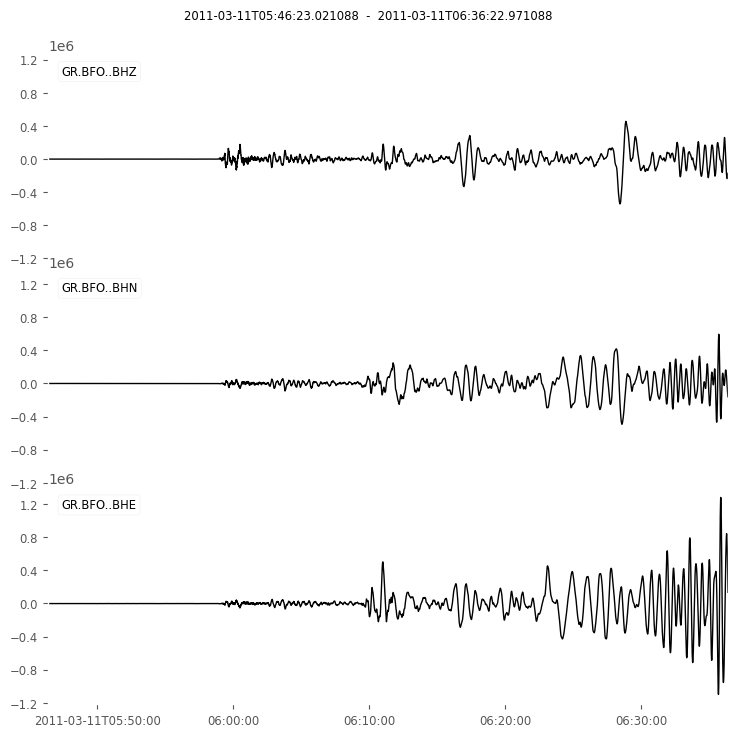

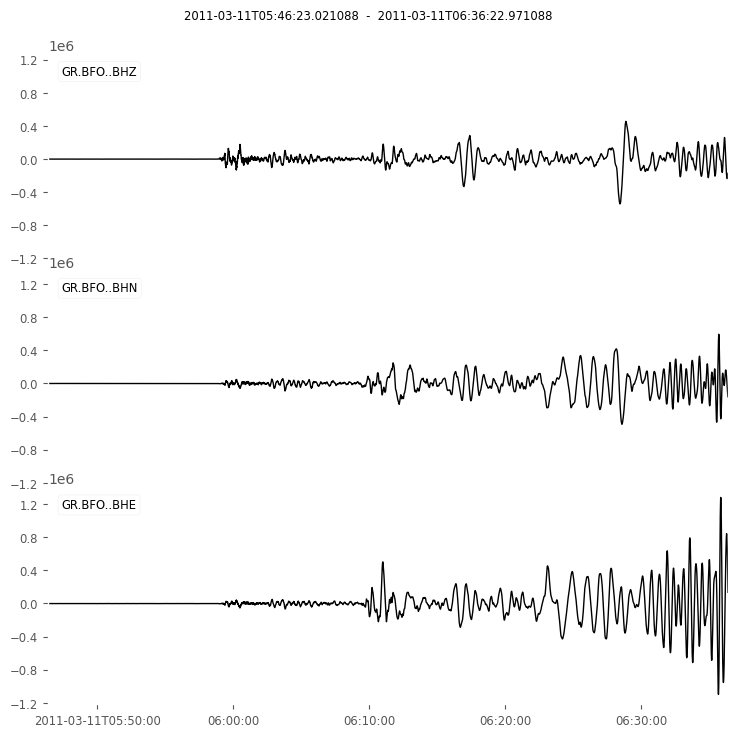

In [11]:
st1 = st.select(station="BFO")
st1.plot()

- trim the data to a 10 minute time window around the first arrival (just roughly looking at the preview plot)
- display the preview plot and spectrograms for the stream (with logarithmic frequency scale, use `wlen=50` for the spectrogram plot)

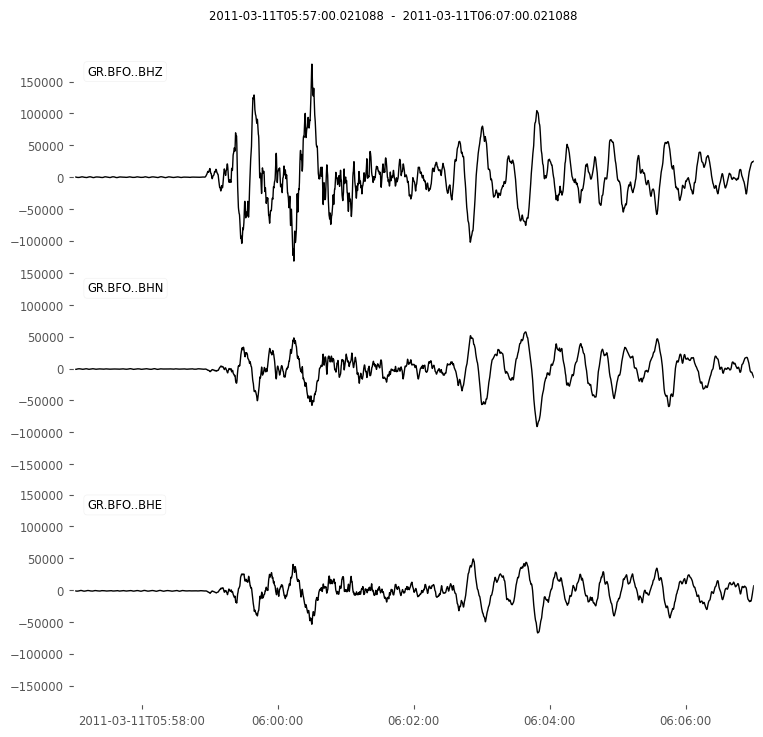

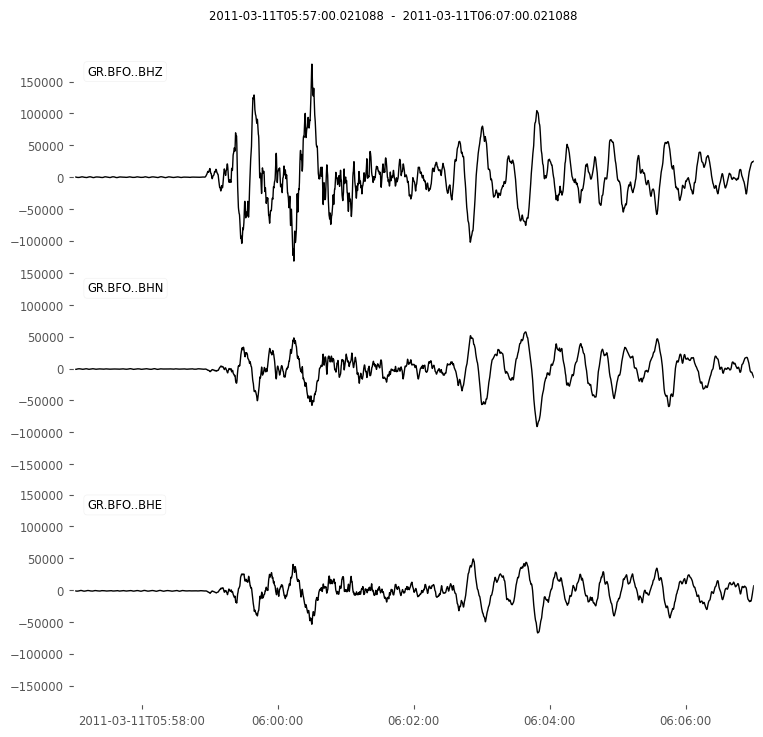

In [12]:
start = UTCDateTime(2011,3,11,5,57)
st1.trim(start,start+10*60)
st1.plot()

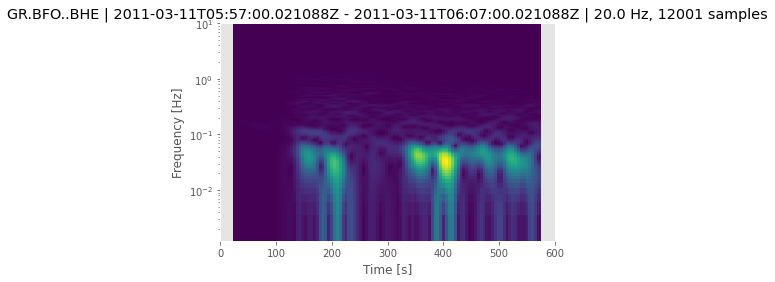

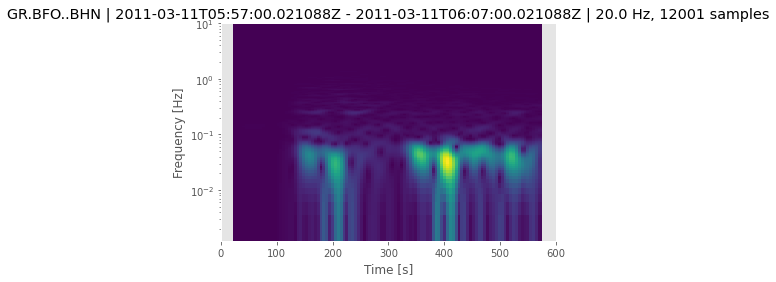

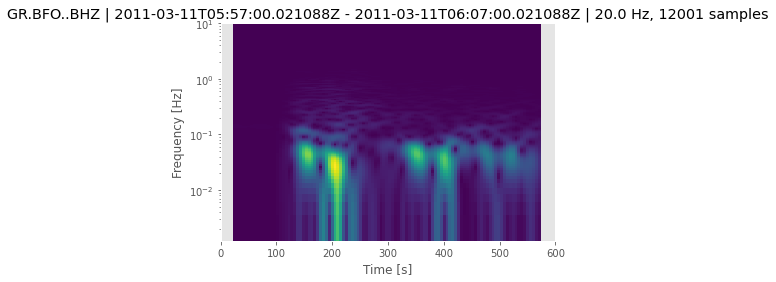

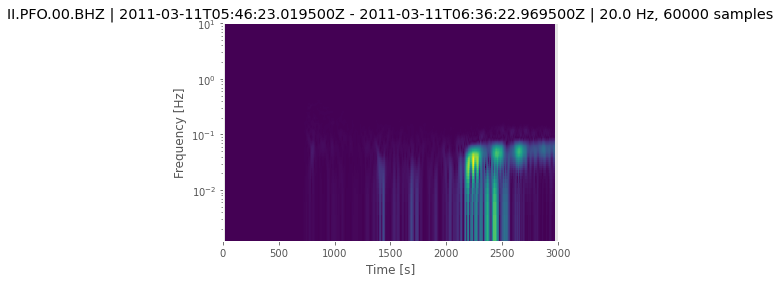

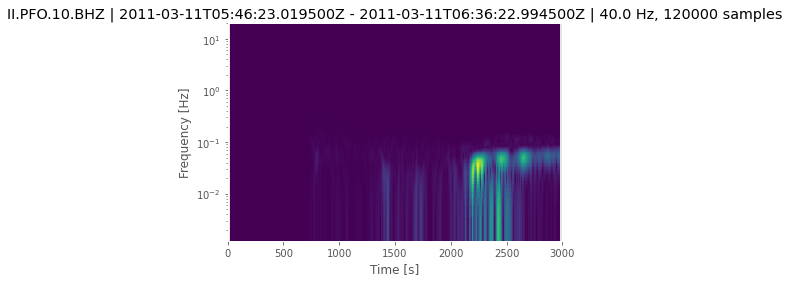

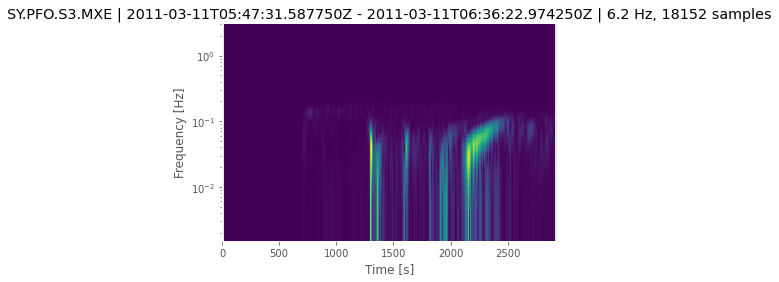

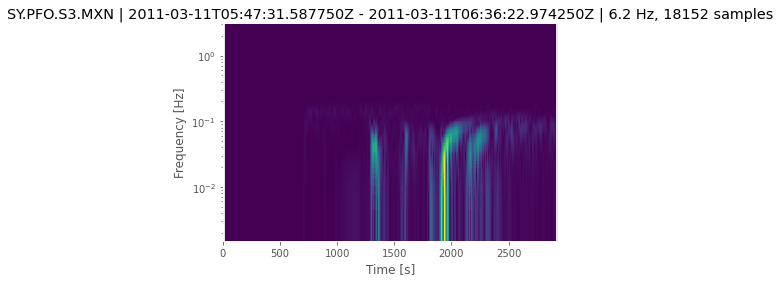

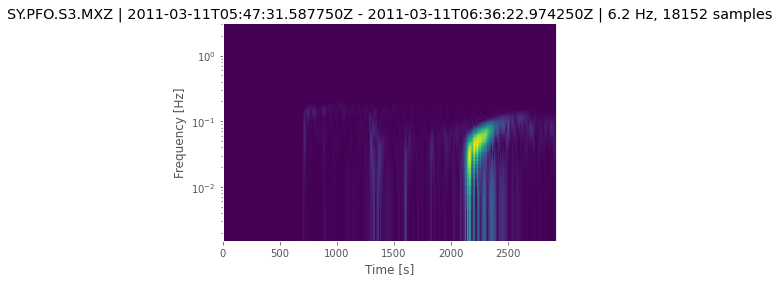

[None, None, None, None, None, None, None, None]

In [17]:
st.spectrogram(log=True,wlen=50)

- remove the linear trend from the data, apply a tapering and a lowpass at 0.1 Hertz
- show the preview plot again

In [20]:
st1.detrend("linear")
st1.taper(0.1,type="cosine")
st1.filter("lowpass",freq=0.1)


3 Trace(s) in Stream:
GR.BFO..BHE | 2011-03-11T05:57:00.021088Z - 2011-03-11T06:07:00.021088Z | 20.0 Hz, 12001 samples
GR.BFO..BHN | 2011-03-11T05:57:00.021088Z - 2011-03-11T06:07:00.021088Z | 20.0 Hz, 12001 samples
GR.BFO..BHZ | 2011-03-11T05:57:00.021088Z - 2011-03-11T06:07:00.021088Z | 20.0 Hz, 12001 samples

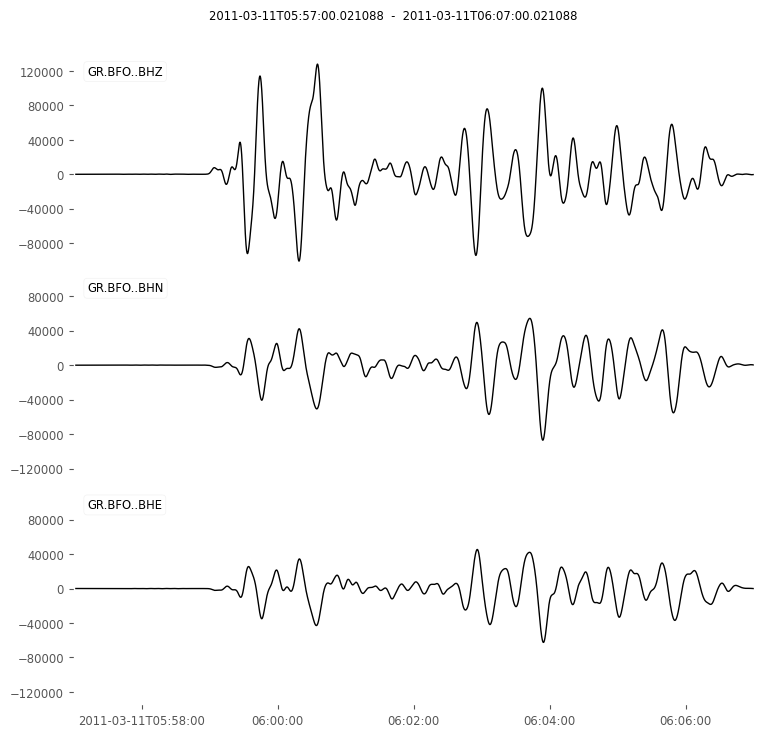

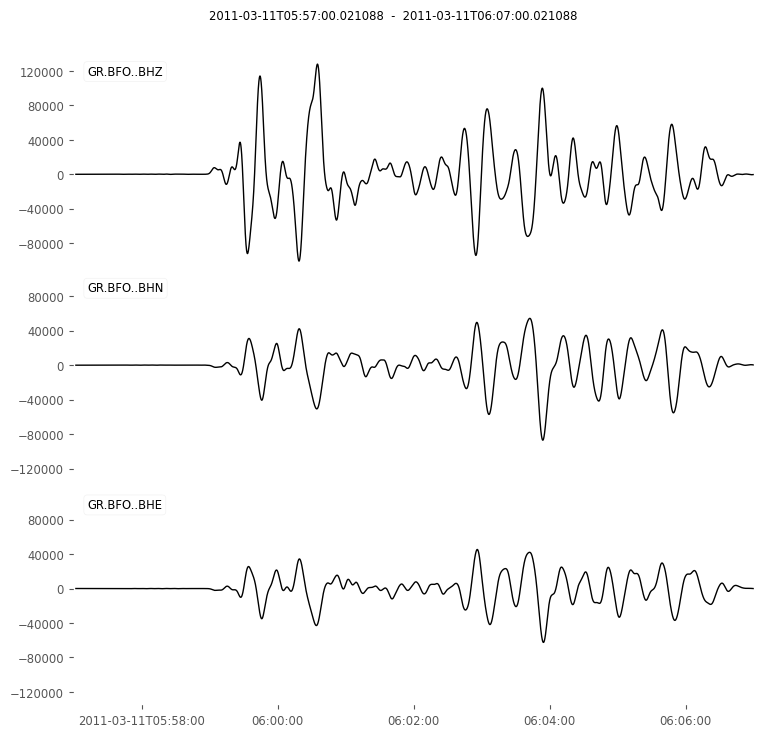

In [21]:
st1.plot()